<span style="color: green;">

# Introduction

In this laboratory we will get our hands dirty working with Large Language Models (e.g. GPT and BERT) to do various useful things. I you haven't already, it is highly recommended to:

- Read the [Attention is All you Need](https://arxiv.org/abs/1706.03762) paper, which is the basis for all transformer-based LLMs.
- Watch (and potentially _code along_) with this [Andrej Karpathy video](https://www.youtube.com/watch?v=kCc8FmEb1nY) which shows you how to build an autoregressive GPT model from the ground up.

# Exercise 1: Warming Up

In this first exercise you will train a _small_ autoregressive GPT model for character generation (the one used by Karpathy in his video) to generate text in the style of Dante Aligheri. Use [this file](https://archive.org/stream/ladivinacommedia00997gut/1ddcd09.txt), which contains the entire text of Dante's Inferno (**note**: you will have to delete some introductory text at the top of the file before training). Train the model for a few epochs, monitor the loss, and generate some text at the end of training. Qualitatively evaluate the results
</span>


## Pipeline

- scarica il file
- elimina la parte iniziale per fare il training
- tokenizza il testo
- crea il modello
- training (per poche epoche)
- guarda la loss
- genera testo e valuta qualitativamente i risultati


In [ ]:
# conda create --name Lab2_DLA
# conda install pytorch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 pytorch-cuda=11.8 -c pytorch -c nvidia
# conda install -c conda-forge transformers
# pip install scikit-learn
# pip install evaluate
# pip install transformers[torch]

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F


import os
import matplotlib.pyplot as plt
import numpy as np

from transformers import GPT2Tokenizer, GPT2LMHeadModel, GenerationConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import GPT2ForSequenceClassification
from transformers import TrainingArguments, Trainer

from datasets import load_dataset
import evaluate

/home/dl23vitcas/anaconda3/envs/Lab2_DLA/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
i = 0
if torch.cuda.is_available():
    device = torch.device("cuda:" + str(i))  # cuda:0 , cuda:1
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # yes, i have a MacBookPro with M1 Pro
else:
    device = torch.device("cpu")

print(f"device: {device}")
print(
    "GPU: " + torch.cuda.get_device_name(i)
    if device == torch.device("cuda:" + str(i))
    else ""
)

In [ ]:
batch_size = 64  # how many indipendent sequences will be process in parallel ?
# what is the maximum context length for predictions ?
block_size = 256  # contect_lenght
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2

In [ ]:
torch.manual_seed(1337)

In [ ]:
print("dataset\n")
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()
print(f"lenght of dataset in characters: {len(text)}\n")

chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f'chars: {"".join(chars)}')
print(f"vocab_size: {vocab_size}")
# print(text[:400])

In [ ]:
# create a mapping from character to integers
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}

# encoder: take a string, output a list of integer
encode = lambda s: [stoi[c] for c in s]
# decoder: take a list of integer, output a string
decode = lambda l: "".join(itos[i] for i in l)

print(encode("Ciao Vittorio"))
print(decode(encode("Ciao Vittorio")))

In [ ]:
# let's now encode the entire text dataset and store it into a torch.Tensor
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:200])
# the 200 characters we looked at earlier will to the GPT look like this

In [ ]:
n = int(0.9 * len(data))  # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [ ]:
print(train_data.shape)
print(train_data[:10])
print(f"Context lenght: {block_size}")

train_data[: block_size + 1]  # chunk of data

In [ ]:
x = train_data[:block_size]
y = train_data[1 : block_size + 1]
print(f"Context lenght: {block_size}")
for t in range(block_size):
    context = x[: t + 1]
    target = y[t]
    print(f"when input is {context} the target is {target}")

    if t == 10:
        break

In [ ]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == "train" else val_data
    ix = torch.randint(low=0, high=len(data) - block_size, size=(batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y


xb, yb = get_batch("train")

print("input: ")
print(f"{xb.shape}\n{xb}")
print("target: ")
print(f"{yb.shape}\n{yb}")

print("---")

for b in range(batch_size):  # 0 --> 4
    for t in range(block_size):  # 0 --> 8
        context = xb[b, : t + 1]
        target = yb[b, t]
        print(f"when input is {context} the target is {target}")
    break

In [ ]:
# Model

torch.manual_seed(1337)


class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=n_embd
        )
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        self.blocks = nn.Sequential(
            *[Block(n_embd, n_head=n_head) for _ in range(n_layer)]
        )
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(
            torch.arange(T, device=device)
        )  # (T, C )
        x = tok_emb + pos_emb  # (B, T, C)
        x = self.blocks(x)  # (B, T, C)
        x = self.ln_f(x)
        logits = self.lm_head(x)  # (B,T, vocab_size)
        # n.b: cross entropy vuole i logits con shape (B * T, C) e non (B, T, C)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    # function to generate from the model
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context

        for _ in range(max_new_tokens):
            # crop idx to the last block_size torkens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)  # logits.shape = (B * T, C)
            # focus only in the last time step
            logits = logits[:, -1, :]  # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append samples index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        return idx


class Head(nn.Module):
    """one head of sel-attention"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)  # (B, T, C)
        q = self.query(x)  # (B, T, C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1)  # (B, T, C) @ (B, C, T) --> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))  # (B, T, T)
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x)  # (B, T, C)
        out = wei @ v  # (B, T, T) @ (B,T,C) --> (B, T, C)
        return out


class MultiHeadAttention(nn.Module):
    """multiple heads of self-attention in parallell"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedForward(nn.Module):
    """a simple linear layer followed by a non-linearity"""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """Trasformer block: communication followed by computation"""

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
model = BigramLanguageModel()
m = model.to(device)
print(sum(p.numel() for p in m.parameters()) / 1e6, "M parameters")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
os.makedirs("./text_generation_model/", exist_ok=True)

path_models = "./text_generation_model/model.pth"

if not os.path.exists(path_models):  # se non esiste fai l'addestramento
    for iter in range(max_iters):
        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0:
            losses = estimate_loss(model)
            print(
                f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
            )
        xb, yb = get_batch("train")
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        torch.save(model.state_dict(), path_models)
else:
    print(f"Model exist on path {path_models}")

In [ ]:
# model.load_state_dict(torch.load(path_models)) # questa istruzione crea problemi se addestro su gpu su papavero e provo a caricare i pesi su mps o cpu, usa torhc.load specificando map_location il dispositivo mps o cpu
# torch.load(path_models, map_location=device)

model.load_state_dict(torch.load(path_models, map_location=device))

max_new_tokens = 5000

# generates text
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=max_new_tokens)[0].tolist()))
# il testo generato a seguito dell'addestramento dovrebbe avere senso

Il testo generato ha una grande somiglianza con lo stile di scrittura del noto poeta Dante. Si può notare come le frasi siano corte e risultano suddivise in gruppi di tre frase (chiamate "terzine"). Ogni terzina ha le due ultime due frasi "indentate" a destra. La maggiorparte delle parole hanno un senso nella lingua italiana, altre invece contengono dei semplici errori di lettere all'interno.
Altra fattore da evidenziare è che il modello spesso riesce a capire che quando siamo all'inizio di una conversazione e viene posto il carattere ":" prima del suo inizio.

Sicuramente con un addestramento con più epoche avremmo un risultato molto migliore ricco di altre caratteristiche dello stile di dante.


<span style="color: green;">

# Exercise 2: Working with Real LLMs

Our toy GPT can only take us so far. In this exercise we will see how to use the [Hugging Face](https://huggingface.co/) model and dataset ecosystem to access a _huge_ variety of pre-trained transformer models.

## Exercise 2.1: Installation and text tokenization

First things first, we need to install the [Hugging Face transformer library](https://huggingface.co/docs/transformers/index):

    conda install -c huggingface -c conda-forge transformers

The key classes that you will work with are `GPT2Tokenizer` to encode text into sub-word tokens, and the `GPT2LMHeadModel`. **Note** the `LMHead` part of the class name -- this is the version of the GPT2 architecture that has the text prediction heads attached to the final hidden layer representations (i.e. what we need to **generate** text).

Instantiate the `GPT2Tokenizer` and experiment with encoding text into integer tokens. Compare the length of input with the encoded sequence length.

**Tip**: Pass the `return_tensors='pt'` argument to the togenizer to get Pytorch tensors as output (instead of lists).
</span>


In [2]:
# installa HF transformers (DONE)
# è stato necessario eseguire anche --> conda install -c conda-forge huggingface_hub (DONE)
# encode text into sub-word tokens with GPT2Tokenizer (DONE)
# istanzia GPT2Tokenizer e converti il testo in token interi (DONE)
# confronta la lunghezza dell'input (testo) con la lunghezza della sequenza codificata (lunghezza della sequenza di interi) (DONE)
# ricordati di usare return_tensors='pt' in modo da ottenere un tensore torch (DONE)
# usa come modello GPT2LMHeadModel (questo modello ha un'uscita apposita per generare il testo)

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# stampa gli attributi e i metodi che posso invocare con l'oggetto tokenizer
# print(*dir(tokenizer), sep="\n")
# print(tokenizer.get_vocab) # important params settings

print(f"Vocab size: {tokenizer.vocab_size}")
print(f"Model max length: {tokenizer.model_max_length}\n")

print(tokenizer.encode("Hi Vittorio"))  # dict with keys: input_ids, attention_mask
print(tokenizer.decode(tokenizer.encode("Hi Vittorio")))

Vocab size: 50257
Model max length: 1024

[17250, 569, 715, 40974]
Hi Vittorio


In [4]:
def view_encoded_text(text, huge=False):
    encoded_text = tokenizer(text, return_tensors="pt")["input_ids"]
    contents = f"{text} --> {encoded_text}" if huge == False else ""
    print(
        f"° length text (in characters): {len(text)} - length encoded text: {encoded_text.shape[1]}\t {contents}"
    )

In [5]:
print("Esempi:\n")
view_encoded_text("Good Morning!")
view_encoded_text(" Good Morning!")
view_encoded_text("  Good Morning!")
view_encoded_text("   Good Morning!")
view_encoded_text("Good Morning!   ")
view_encoded_text("Good Morning!  ")
view_encoded_text("Good Morning! ")
view_encoded_text("Good Morning!")

Esempi:

° length text (in characters): 13 - length encoded text: 3	 Good Morning! --> tensor([[10248, 14410,     0]])
° length text (in characters): 14 - length encoded text: 3	  Good Morning! --> tensor([[ 4599, 14410,     0]])
° length text (in characters): 15 - length encoded text: 4	   Good Morning! --> tensor([[  220,  4599, 14410,     0]])
° length text (in characters): 16 - length encoded text: 5	    Good Morning! --> tensor([[  220,   220,  4599, 14410,     0]])
° length text (in characters): 16 - length encoded text: 6	 Good Morning!    --> tensor([[10248, 14410,     0,   220,   220,   220]])
° length text (in characters): 15 - length encoded text: 5	 Good Morning!   --> tensor([[10248, 14410,     0,   220,   220]])
° length text (in characters): 14 - length encoded text: 4	 Good Morning!  --> tensor([[10248, 14410,     0,   220]])
° length text (in characters): 13 - length encoded text: 3	 Good Morning! --> tensor([[10248, 14410,     0]])


Da notare che la lunghezza del testo codificato tiene conto del numero di parole e della punteggiatura (carattere spazio incluso).
Per evitare di scrivere un programma che conti il numero di parole e il numero di caratteri della punteggiatura contiamo i caratteri della testo come avevamo fatto nel precedente esercizio.

Si può notare che all'aumentare/diminuire della lunghezza del testo aumenta/diminuisce la lunghezza della sequenza di interi. Però fra le due lenght non c'è una corrispondenza biunivoca (per esempio ad un testo di 13 caratteri potrebbero corrispondere una codifica con 3 o 4 interi come si può vedere negli esempi sopra).
Si può notare inoltre che l'aggiunta di tanti spazi fa aumentare la lunghezza della sequenza di interi. Questo potrebbe essere uno svantaggio in certi casi. In genere l'aggiunta di più di uno spazio nella scrittura con tastiera qwerty è un'errore di battitura che però un modello di linguaggio codifica come input di testo grezzo e potrebbe creare delle relazioni tra parole successive.

Proviamo con esempi di testo più lunghi.


In [6]:
view_encoded_text(
    "My name is Vittorio Casula. I'm 26 years old. I graduated in Computer Engineering in 2021 at University of Florence.",
    huge=True,
)
view_encoded_text(
    "My best purchase of the last 2 years is my Macbook Pro with M1 Pro Processor. Thanks to it, I'm able to run fast my Machine Learning Script on my laptop.",
    huge=True,
)
view_encoded_text(
    "However, I believe that the optimal setup for working in the Machine Learning field should involve two devices: the first being a laptop (not necessarily a MacBook) with a large-capacity battery, and the second being a server (connected via SSH) on which you can run your scripts without utilizing the resources of the laptop.",
    huge=True,
)

° length text (in characters): 116 - length encoded text: 27	 
° length text (in characters): 153 - length encoded text: 37	 
° length text (in characters): 326 - length encoded text: 64	 


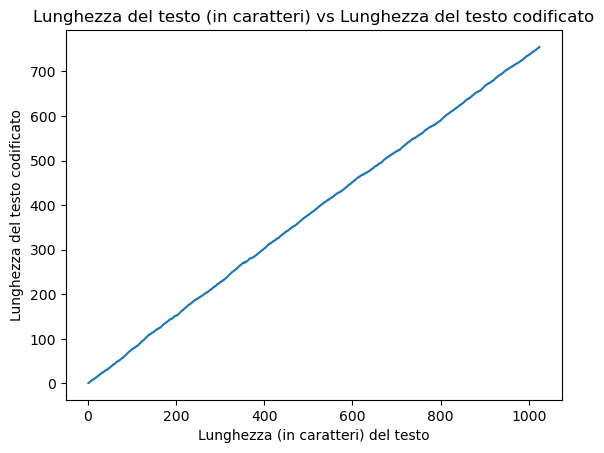

In [7]:
# proviamo a fare una stringa dinamica che diventa sempre più lunga

dynamic_str = ""
len_max = 1024
chars = f"ABCDEFGHILMNOPQRSTUVXZabcdefghijlmnopqrstuvxz0123456789"
indices = torch.randint(low=0, high=len(chars), size=(len_max,)).tolist()

lengths_text = []
lengths_encoded_text = []
for i in range(len(indices)):
    dynamic_str += chars[indices[i]]
    lengths_text.append(len(dynamic_str))
    lengths_encoded_text.append(
        tokenizer(dynamic_str, return_tensors="pt")["input_ids"].shape[1]
    )

plt.title("Lunghezza del testo (in caratteri) vs Lunghezza del testo codificato")
plt.xlabel("Lunghezza (in caratteri) del testo")
plt.ylabel("Lunghezza del testo codificato")

plt.plot(lengths_text, lengths_encoded_text)

<span style="color: green;">

## Exercise 2.2: Generating Text

There are a lot of ways we can, given a _prompt_ in input, sample text from a GPT2 model. Instantiate a pre-trained `GPT2LMHeadModel` and use the [`generate()`](https://huggingface.co/docs/transformers/v4.27.2/en/main_classes/text_generation#transformers.GenerationMixin.generate) method to generate text from a prompt.

**Note**: The default inference mode for GPT2 is _greedy_ which might not results in satisfying generated text. Look at the `do_sample` and `temperature` parameters.
</span>


In [8]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

input_text = "My name is Vittorio. I'm AI student at University of Florence."

inputs = tokenizer(input_text, return_tensors="pt")
# print(inputs)
# print(*inputs)  # get the keys of returned dict
# outputs = model.generate(**inputs) # warning: Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
outputs = model.generate(**inputs, pad_token_id=tokenizer.eos_token_id)
# print(outputs)
print(f"Generated text: \n{tokenizer.decode(outputs[0])}")
# if you want decode multiple interger sequence you should use batch_decode()

Generated text: 
My name is Vittorio. I'm AI student at University of Florence. I'm a member


/home/dl23vitcas/anaconda3/envs/Lab2_DLA/lib/python3.11/site-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [9]:
# interesting warning:Using the model-agnostic default `max_length` (=20) to control thegeneration length.
# We recommend setting `max_new_tokens` to control the maximum length of the generation.

outputs = model.generate(
    **inputs, pad_token_id=tokenizer.eos_token_id, max_new_tokens=100
)
# print(outputs)
print("Generated text: \n")
print(tokenizer.decode(outputs[0]))

Generated text: 

My name is Vittorio. I'm AI student at University of Florence. I'm a member of the Italian National Team. I'm a member of the Italian National Team. I'm a member of the Italian National Team. I'm a member of the Italian National Team. I'm a member of the Italian National Team. I'm a member of the Italian National Team. I'm a member of the Italian National Team. I'm a member of the Italian National Team. I'm a member of the Italian National Team. I'm a member of the Italian National Team.


Come vediamo il testo generato contiene il testo iniziamente codificato e una frase generata che si ripete fino a raggiungere il numero massimo di token specificato. Non ha molto senso questo testo generato.


In [10]:
# check "do_sample" and "temperature" parameters
# link: https://huggingface.co/docs/transformers/generation_strategies

In [11]:
print(model.generation_config)
# Printing out the model.generation_config reveals only the values that are different from the default generation configuration,
# and does not list any of the default values.

# The default generation configuration limits the size of the output combined with the input prompt to a maximum of 20 tokens
# to avoid running into resource limitations. The default decoding strategy is greedy search, which is the simplest decoding
# strategy that picks a token with the highest probability as the next token. For many tasks and small output sizes this works well.
# However, when used to generate longer outputs, greedy search can start producing highly repetitive results.

GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 50256,
  "eos_token_id": 50256,
  "transformers_version": "4.31.0"
}



### Customize Text Generation


do_sample: if set to True, this parameter enables decoding strategies such as multinomial sampling, beam-search multinomial sampling,
Top-K sampling and Top-p sampling. All these strategies select the next token from the probability distribution over the entire vocabulary
with various strategy-specific adjustments.


In [12]:
outputs = model.generate(
    **inputs, pad_token_id=tokenizer.eos_token_id, max_new_tokens=100, do_sample=True
)
# print(outputs)
print("Generated text: \n")
print(tokenizer.decode(outputs[0]))

Generated text: 

My name is Vittorio. I'm AI student at University of Florence. My best guess is that I've become a supercomputer genius. Idestroy you all, with a lot of dedication, of course in order to prove to myself you are the master of everything in your field. I would love for you to do not only on my computer screen but also on any screen and also on your computer and as it is only right that I prove to you that you are the best master by that means. I also believe that your ability to create beautiful work using this way comes


In [13]:
generation_config = GenerationConfig(
    max_new_tokens=50,
    do_sample=True,
    top_k=50,
    eos_token_id=model.config.eos_token_id,
    pad_token_id=tokenizer.eos_token_id,
)

outputs = model.generate(**inputs, generation_config=generation_config)
# print(outputs)
print("Generated text: \n")
print(tokenizer.decode(outputs[0]))

Generated text: 

My name is Vittorio. I'm AI student at University of Florence. I am an intelligent AI expert. I have a big life, a beautiful wife and dog. I can see all the world and not have to worry about my own emotions. And I do all the things that a human doesn't have the power to


Assisted decoding is a modification of the decoding strategies above that uses an assistant model with the same tokenizer (ideally a much smaller model) to greedily generate a few candidate tokens. The main model then validates the candidate tokens in a single forward pass, which speeds up the decoding process. Currently, only greedy search and sampling are supported with assisted decoding, and doesn’t support batched inputs. To learn more about assisted decoding, check this blog post.


When using assisted decoding with sampling methods, you can use the temperature argument to control the randomness just like in multinomial sampling. However, in assisted decoding, reducing the temperature will help improving latency.


In [14]:
temperature = [0.2, 0.4, 0.6, 0.8, 1]
for temp in temperature:
    outputs = model.generate(
        **inputs, generation_config=generation_config, do_sample=True, temperature=temp
    )
    # print(outputs)
    print(f"\n° Generated text (temperature = {temp}):")
    print(f"{tokenizer.decode(outputs[0])}")


° Generated text (temperature = 0.2):
My name is Vittorio. I'm AI student at University of Florence. I'm a computer science major. I'm a computer science major. I'm a computer science major. I'm a computer science major. I'm a computer science major. I'm a computer science major. I'm a computer science major. I

° Generated text (temperature = 0.4):
My name is Vittorio. I'm AI student at University of Florence. I'm a very talented programmer. I'm a very smart guy. I'm very good at my job. I'm very good at my job. I'm very good at my job. I'm very good at my job. I'm very good

° Generated text (temperature = 0.6):
My name is Vittorio. I'm AI student at University of Florence. I'm a member of the Italian Committee for Human Rights. I'm a member of the Italian Committee for Human Rights. I'm a member of the Italian Committee for Human Rights.

In May, I was elected President of the Italian Committee for

° Generated text (temperature = 0.8):
My name is Vittorio. I'm AI student at Univer

Testo generato molto vario al crescere del parametro temperature. Per piccoli valori di temperature si ha il fenomeno della ripetizione del testo.


<span style="color: green;">

# Exercise 3: Reusing Pre-trained LLMs (choose one)

Choose **one** of the following exercises (well, _at least_ one). In each of these you are asked to adapt a pre-trained LLM (`GPT2Model` or `DistillBERT` are two good choices) to a new Natural Language Understanding task. A few comments:

- Since GPT2 is a _autoregressive_ model, there is no latent space aggregation at the last transformer layer (you get the same number of tokens out that you give in input). To use a pre-trained model for a classification or retrieval task, you should aggregate these tokens somehow (or opportunistically select _one_ to use).

- BERT models (including DistillBERT) have a special [CLS] token prepended to each latent representation in output from a self-attention block. You can directly use this as a representation for classification (or retrieval).

- The first _two_ exercises below can probably be done _without_ any fine-tuning -- that is, just training a shallow MLP to classify or represent with the appropriate loss function.

# Exercise 3.1: Training a Text Classifier (easy) <span style="color: red;">(DONE)</span>

Peruse the [text classification datasets on Hugging Face](https://huggingface.co/datasets?task_categories=task_categories:text-classification&sort=downloads). Choose a _moderately_ sized dataset and use a LLM to train a classifier to solve the problem.

**Note**: A good first baseline for this problem is certainly to use an LLM _exclusively_ as a feature extractor and then train a shallow model.

# Exercise 3.2: Training a Question Answering Model (harder)

Peruse the [multiple choice question answering datasets on Hugging Face](https://huggingface.co/datasets?task_categories=task_categories:multiple-choice&sort=downloads). Chose a _moderately_ sized one and train a model to answer contextualized multiple-choice questions. You _might_ be able to avoid fine-tuning by training a simple model to _rank_ the multiple choices (see margin ranking loss in Pytorch).

# Exercise 3.3: Training a Retrieval Model (hardest)

The Hugging Face dataset repository contains a large number of ["text retrieval" problems](https://huggingface.co/datasets?task_categories=task_categories:text-retrieval&p=1&sort=downloads). These tasks generally require that the model measure _similarity_ between text in some metric space -- naively, just a cosine similarity between [CLS] tokens can get you pretty far. Find an interesting retrieval problem and train a model (starting from a pre-trained LLM of course) to solve it.

**Tip**: Sometimes identifying the _retrieval_ problems in these datasets can be half the challenge. [This dataset](https://huggingface.co/datasets/BeIR/scifact) might be a good starting point.
</span>


In [15]:
# prendere un modello pre-addestrato e adattarlo ad un nuovo task
# non occorre fare fine-tuning
# addestrare uno shallow MLP per classificare o rappresentare con una loss function
# dataset: sceglierne uno di moderate dimensioni
# LLM: GPT2
# usare LLM esclusivamente come feature extractor
# addestrare uno shallow MLP

In [16]:
dataset = load_dataset("tweet_eval", "emoji")

In [17]:
print(dataset["train"].shape)
print(dataset["test"].shape)
print(dataset["validation"].shape)

(45000, 2)
(50000, 2)
(5000, 2)


In [18]:
dataset["train"][:5]

{'text': ['Sunday afternoon walking through Venice in the sun with @user ️ ️ ️ @ Abbot Kinney, Venice',
  "Time for some BBQ and whiskey libations. Chomp, belch, chomp! (@ Lucille's Smokehouse Bar-B-Que)",
  'Love love love all these people ️ ️ ️ #friends #bff #celebrate #blessed #sundayfunday @ San…',
  '️ ️ ️ ️ @ Toys"R"Us',
  'Man these are the funniest kids ever!! That face! #HappyBirthdayBubb @ FLIPnOUT Xtreme'],
 'label': [12, 19, 0, 0, 2]}

In [19]:
id2label = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
    10: "10",
    11: "11",
    12: "12",
    13: "13",
    14: "14",
    15: "15",
    16: "16",
    17: "17",
    18: "18",
    19: "19",
}
label2id = {
    "0": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5,
    "6": 6,
    "7": 7,
    "8": 8,
    "9": 9,
    "10": 10,
    "11": 11,
    "12": 12,
    "13": 13,
    "14": 14,
    "15": 15,
    "16": 16,
    "17": 17,
    "18": 18,
    "19": 19,
}

In [20]:
"""
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

tokenizer.add_special_tokens({"pad_token": "[PAD]"})
# Puoi sostituire '[PAD]' con il token di padding desiderato
tokenizer.pad_token = "[PAD]"  # Imposta il token appena aggiunto come token di padding

tokenized_tweet_eval = dataset.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
accuracy = evaluate.load("accuracy")

model = GPT2ForSequenceClassification.from_pretrained(
    "gpt2", num_labels=20, id2label=id2label, label2id=label2id
)

model.config.pad_token_id = model.config.eos_token_id"""

'\ndef preprocess_function(examples):\n    return tokenizer(examples["text"], truncation=True, padding=True)\n\n\ndef compute_metrics(eval_pred):\n    predictions, labels = eval_pred\n    predictions = np.argmax(predictions, axis=1)\n    return accuracy.compute(predictions=predictions, references=labels)\n\n\ntokenizer = GPT2Tokenizer.from_pretrained("gpt2")\n\ntokenizer.add_special_tokens({"pad_token": "[PAD]"})\n# Puoi sostituire \'[PAD]\' con il token di padding desiderato\ntokenizer.pad_token = "[PAD]"  # Imposta il token appena aggiunto come token di padding\n\ntokenized_tweet_eval = dataset.map(preprocess_function, batched=True)\n\ndata_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")\naccuracy = evaluate.load("accuracy")\n\nmodel = GPT2ForSequenceClassification.from_pretrained(\n    "gpt2", num_labels=20, id2label=id2label, label2id=label2id\n)\n\nmodel.config.pad_token_id = model.config.eos_token_id'

In [21]:
"""from transformers import AutoTokenizer


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)


tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# tokenizer = AutoTokenizer.from_pretrained("gpt-2")

tokenizer.add_special_tokens({"pad_token": "[PAD]"})
# Puoi sostituire '[PAD]' con il token di padding desiderato
tokenizer.pad_token = "[PAD]"  # Imposta il token appena aggiunto come token di padding


tokenized_tweet_eval = dataset.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
accuracy = evaluate.load("accuracy")"""
pass

In [22]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print(tokenizer)
tokenizer.pad_token = tokenizer.eos_token

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True)


In [23]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)


tokenized_tweet_eval = dataset.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
accuracy = evaluate.load("accuracy")

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(
    "gpt2", num_labels=20, id2label=id2label, label2id=label2id
)
model.config.pad_token_id = model.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
training_args = TrainingArguments(
    output_dir="./text_classification_model/",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    optim="adamw_torch"
    # no_cuda=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_tweet_eval["train"],
    eval_dataset=tokenized_tweet_eval["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [26]:
trainer.train()

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/dl23vitcas/anaconda3/envs/Lab2_DLA/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,2.065100,1.877118,0.424640
2,1.844900,1.803294,0.446840
3,1.741600,1.788996,0.451840
4,1.659100,1.787817,0.455260
5,1.610400,1.802986,0.457220


/home/dl23vitcas/anaconda3/envs/Lab2_DLA/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/dl23vitcas/anaconda3/envs/Lab2_DLA/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/dl23vitcas/anaconda3/envs/Lab2_DLA/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/dl23vitcas/anaconda3/envs/Lab2_DLA/lib/python3.11/site-packages/torch/nn/parallel/

TrainOutput(global_step=7035, training_loss=1.805658001279526, metrics={'train_runtime': 4086.3897, 'train_samples_per_second': 55.061, 'train_steps_per_second': 1.722, 'total_flos': 1.345377152249856e+16, 'train_loss': 1.805658001279526, 'epoch': 5.0})

In [27]:
trainer.evaluate()

/home/dl23vitcas/anaconda3/envs/Lab2_DLA/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 1.7878170013427734,
 'eval_accuracy': 0.45526,
 'eval_runtime': 165.3727,
 'eval_samples_per_second': 302.347,
 'eval_steps_per_second': 9.451,
 'epoch': 5.0}

In [28]:
path_models = "text_classification_model"

sequence_to_classify = "merry cristhmas"

model.save_pretrained(path_models)
model = AutoModelForSequenceClassification.from_pretrained(path_models)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

encoded_sequence = tokenizer(sequence_to_classify, return_tensors="pt")

logits = model(**encoded_sequence).logits
predicted_class = logits.argmax().item()

print(f"Classe predetta: {predicted_class}")

Classe predetta: 17
